![](https://storage.googleapis.com/kaggle-competitions/kaggle/30894/logos/header.png)
# G-Research Crypto - Modélisation (FR)

Dans le concours de prédiction G-Research Crypto, les participants ont le défi de prédire les rendements des prix sur un ensemble de crypto-monnaies majeures.

Références utilisées : 
* [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)
* [G-Research Crypto - Starter XGB Pipeline](https://www.kaggle.com/tarlannazarov/g-research-crypto-starter-xgb-pipeline)
* [LGDM model with new features better generalization](https://www.kaggle.com/swaralipibose/lgdm-model-with-new-features-better-generalization)

---
# Chargement

## Libraries et Fonctions

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from sklearn import model_selection, preprocessing, linear_model, metrics, pipeline
from lightgbm import LGBMRegressor
from datetime import datetime

In [2]:
def reduce_mem_usage(df):
    """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def plot_them(y_train, y_test, y_test_pred, first=30):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(y_train.index[-100000:], y_train.iloc[-100000:])
    plt.plot(y_test.index, y_test)
    plt.plot(y_test.index, y_test_pred)
    plt.legend(['Entrainement', 'Test', 'Prédiction'])

    plt.subplot(1,2,2)
    plt.plot(y_train.index[-first:], y_train.iloc[-first:])
    plt.plot(y_test.index[:first], y_test.iloc[:first])
    plt.plot(y_test.index[:first], y_test_pred[:first])
    plt.plot([y_train.index[-first], y_test.index[first]], [0,0])
    plt.legend(['Entrainement', 'Test', 'Prédiction'])
    plt.show()
 
def ResidualizeMarket(df, mktColumn, window):
    if mktColumn not in df.columns:
        return df

    mkt = df[mktColumn]

    num = df.multiply(mkt.values, axis=0).rolling(window).mean().values  #numerator of linear regression coefficient
    denom = mkt.multiply(mkt.values, axis=0).rolling(window).mean().values  #denominator of linear regression coefficient
    beta = np.nan_to_num( num.T / denom, nan=0., posinf=0., neginf=0.)  #if regression fell over, use beta of 0

    resultRet = df - (beta * mkt.values).T  #perform residualization
    resultBeta = 0.*df + beta.T  #shape beta

    return resultRet.drop(columns=[mktColumn]), resultBeta.drop(columns=[mktColumn])

## Données

In [3]:
data_folder = "../input/g-research-crypto-forecasting/"
data_folder = ""
df = pd.read_csv(data_folder + 'train_cleaned.csv', index_col=0).pipe(reduce_mem_usage)
df_asset_details = pd.read_csv(data_folder + 'asset_details.csv').sort_values("Asset_ID")

Memory usage of dataframe is 2090.26 MB
Memory usage after optimization is: 914.49 MB
Decreased by 56.2%


---
# Préparation

## Cibles de prédiction et évaluation
Ce concours de prévision vise à prédire les rendements dans un futur proche des prix $P^a$, pour chaque actif $a$.
Pour chaque ligne de l'ensemble de données, nous incluons la cible de prédiction, `Target`.
La cible est dérivée des **log return** ($R^a$) sur **15 minutes** :
$$R^a(t)=\log(P^a(t+16) / P^a(t+1))$$

Les rendements des actifs cryptographiques sont fortement corrélés, suivant dans une large mesure le marché global de la cryptographie.
Comme on nous pousse à tester notre capacité à prédire les rendements d'actifs individuels,  une résidualisation linéaire a été effectuée, en supprimant le signal de marché des rendements d'actifs individuels lors de la création de `Target`. 
Plus en détail, si $M(t)$ est la moyenne pondérée des rendements du marché, la cible est :
$$M(t) = \frac{\sum_{a}{w^aR^a(t))}}{\sum_{a}{w^a}}$$
$$\beta^a = \frac{⟨M⋅R^a⟩}{⟨M^2⟩}$$
$$\text{Target}^a(t) = R^a(t)−\beta^aM(t)$$
où la parenthèse $⟨.⟩$ représente la **moyenne mobile** au fil du temps (fenêtres de 3750 minutes), et les mêmes pondérations d'actifs ont été utilisées pour la métrique d'évaluation.

Certaines lignes ont des valeurs nulles pour les cibles en raison de valeurs manquantes dans les prix futurs. 
Les lignes avec des valeurs NULL dans l'ensemble de test sont ignorées à des fins de notation.

Dans la compétition, les prédictions seront évaluées sur une version pondérée du coefficient de corrélation de Pearson, avec des pondérations données par la colonne `Weight` dans le fichier `asset_details.csv`.

## Indicateurs techniques (Feature design)
Avant de chercher des caractéristiques, il y a quelques mises en garde à prendre en compte :
* pas de fuite : nous ne pouvons pas utiliser une fonctionnalité qui utilise les informations futures (il s'agit d'une tâche de prévision)
* caractéristiques stationnaires : les caractéristiques doivent fonctionner à tout moment (les échelles doivent être stationnaires sur des périodes de temps)

Quelques caractéristiques pertinentes potentielles :
* 5 min log return
* abs(5 min log return)
* upper shadow
* lower shadow

In [4]:
def log_return(series, periods=1):
    """Function to compute the log return."""
    return np.log(series).diff(periods=periods)

def RSI(close: pd.DataFrame, period: int=14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def EMA1(x, n):
    """
    https://qiita.com/MuAuan/items/b08616a841be25d29817
    """
    a= 2/(n+1)
    return pd.Series(x).ewm(alpha=a).mean()

def MACD(close : pd.DataFrame, span1=12, span2=26, span3=9):
    """
    Compute MACD
    # https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
    """
    exp1 = EMA1(close, span1)
    exp2 = EMA1(close, span2)
    macd = 100 * (exp1 - exp2) / exp2
    signal = EMA1(macd, span3)

    return macd, signal

def get_features(df_asset):
    df = df_asset[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    
    
    df['price_change'] = df['Close'] / df['Open']
    df['log_price_change'] = np.log(df['price_change'])
    df['trade'] = df['Close'] - df['Open']
    df['candle_len'] = np.abs(df['trade'])
    df['gtrade'] = df['trade'] / (df['Count'] + 1)
    df['mean_trade'] = df['Volume'] / (df['Count'] + 1)
    
    df['high2low'] = df['High'] / df['Low']
    df['spread'] = df['High'] - df['Low']
    median_price = df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df['high2median'] = df['High'] / median_price
    df['low2median'] = df['Low'] / median_price
    
    # df['upper_shadow'] = df['High'] / df[['Close', 'Open']].max(axis=1)
    df['upper_shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    # df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) / df['Low']
    df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']
    df['upper_shadow_log'] = np.log(df['upper_shadow'])
    df['lower_shadow_log'] = np.log(df['lower_shadow'])
    df['shadow1'] = df['trade'] / df['Volume']
    df['shadow2'] = df['upper_shadow'] / df['Low']
    df['shadow3'] = df['upper_shadow'] / df['Volume']
    df['shadow4'] = df['lower_shadow'] / df['High']
    df['shadow5'] = df['lower_shadow'] / df['Volume']
    
    df['log_return1'] = log_return(df['Close'], periods=1)
    df['log_return10'] = log_return(df['Close'], periods=10)
    df['log_return100'] = log_return(df['Close'], periods=100)
    
    times = pd.to_datetime(df.index, unit="s", infer_datetime_format=True)
    df["hour"] = times.hour
    df["dayofweek"] = times.dayofweek 
    df["day"] = times.day 
    
    df["RSI"] = RSI(df["Close"], 14)
    macd, macd_signal = MACD(df["Close"], 12, 26, 9) 
    df["MACD"] = macd
    df["MACD_signal"] = macd_signal
    
    # drops = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
    # df.drop(drops, axis=1, inplace=True)
    return df

## Préparation des données
Comme nous allons entraîner les paramètres de régression linéaire, nous devons séparer les ensembles d'entraînement et de test. 
Pour ce faire, nous calculerons X et y et diviserons ces données en fractions d'entraînement et de test. 
Notons que la fraction pour le test représente une partie ultérieure des données, comme cela est généralement fait dans les séries chronologiques.

Nous normalisons maintenant les données d'entrée. 
La normalisation est le processus consistant à mettre différentes variables sur la même échelle. 
Dans l'analyse de régression, il est souvent crucial de standardiser les variables indépendantes sous peine de risquer d'obtenir des résultats trompeurs.

In [5]:
# Suppresion du futur
df['datetime'] = pd.to_datetime(df.index, unit='s')
df = df[df['datetime'] < '2021-06-13 00:00:00']

In [6]:
df_btc = df[df["Asset_ID"] == 1][:-16]  # Supression des 16 dernières entrées sans Target
df_proc = get_features(df_btc)
df_proc['y'] = df_btc['Target']
df_proc = df_proc.dropna(how="any")

C:\Anaconda3\envs\forecasting\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Anaconda3\envs\forecasting\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Anaconda3\envs\forecasting\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [7]:
X = df_proc.drop("y", axis=1)
y = df_proc["y"]
N = len(X)
test_size = 0.3
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test = X[:-int(N*test_size)], X[-int(N*test_size):]
y_train, y_test = y[:-int(N*test_size)], y[-int(N*test_size):]

In [8]:
scaler = preprocessing.StandardScaler()

## Évaluation des valeurs de référence
La mesure de la performance en compétition est la corrélation pondérée. 
Cependant, pour l'instant, nous utiliserons une simple corrélation pour évaluer les modèles construits.

---
# Modélisation

## Modèle de référence : Régression linéaire
Nous allons essayer un modèle de régression linéaire simple sur les fonctionnalités que nous avons conçues. 
Notons que la régression linéaire n'est pas couramment utilisée dans l'analyse de séries chronologiques, en particulier avec un seul pas de temps !

Nous comparons deux lignes de base de régression linéaire, l'une qui considère chaque actif indépendamment et l'autre à plusieurs entrées qui modélise tous les actifs ensemble.

In [9]:
model = linear_model.LinearRegression()
pipe1 = pipeline.Pipeline(steps=[
    ('scaler', scaler),
    ('linear', model)])
pipe1.fit(X_train, y_train)

y_train_pred = pipe1.predict(X_train)
y_test_pred = pipe1.predict(X_test)

In [10]:
print('     Training | Test')
print(f'MSE  {np.mean((y_train - y_train_pred)**2):8.2e} | {np.mean((y_test - y_test_pred)**2):8.2e}')
print(f'CV   {stats.pearsonr(y_train, y_train_pred)[0]:8.6f} | {stats.pearsonr(y_test, y_test_pred)[0]:8.6f}')

     Training | Test
MSE  3.71e-06 | 2.62e-05
CV   0.058837 | -0.020485


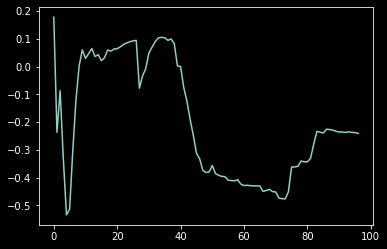

In [11]:
corrs = []
for i in range(3, 100):
    corrs.append( stats.pearsonr(y_test[:i], y_test_pred[:i])[0] )
plt.plot(corrs)
plt.show()

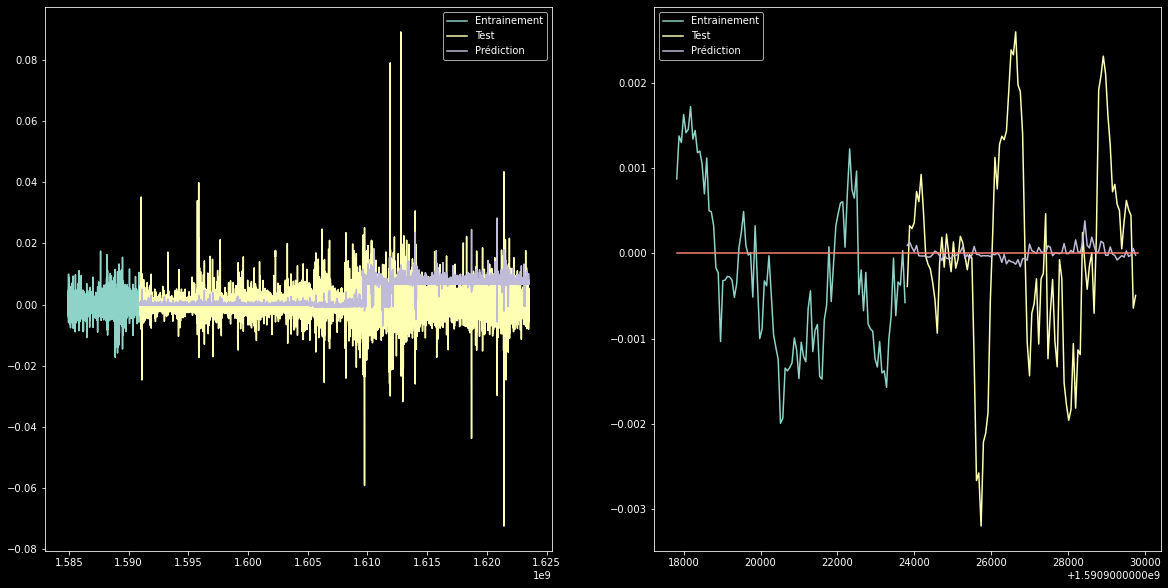

In [12]:
plot_them(y_train, y_test, y_test_pred, first=30)

## LGBM (Ligh Gradient Boosting Machine) Regressor

In [13]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    # 'metric': 'rmse',
    'objective': 'regression',
    'boosting_type': 'gbdt',
    # 'max_depth': -1,
    # 'subsample': 0.72,
    # 'subsample_freq': 4,
    # 'feature_fraction': 0.4,
    # 'lambda_l1': 1,
    # 'lambda_l2': 1,
    # 'seed': 46,
}
model = LGBMRegressor(**params)
pipe2 = pipeline.Pipeline(steps=[
    ('scaler', scaler),
    ('model', model)])
pipe2.fit(X_train, y_train)

y_train_pred = pipe2.predict(X_train)
y_test_pred = pipe2.predict(X_test)

In [14]:
print('     Training | Test')
print(f'MSE  {np.mean((y_train - y_train_pred)**2):8.2e} | {np.mean((y_test - y_test_pred)**2):8.2e}')
print(f'CV   {stats.pearsonr(y_train, y_train_pred)[0]:8.6f} | {stats.pearsonr(y_test, y_test_pred)[0]:8.6f}')

     Training | Test
MSE  3.42e-06 | 9.10e-06
CV   0.317242 | 0.010195


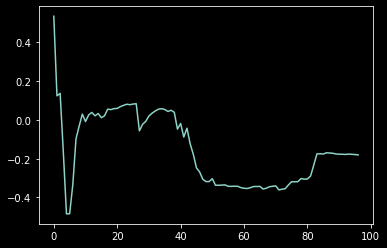

In [15]:
corrs = []
for i in range(3, 100):
    corrs.append( stats.pearsonr(y_test[:i], y_test_pred[:i])[0] )
plt.plot(corrs)
plt.show()

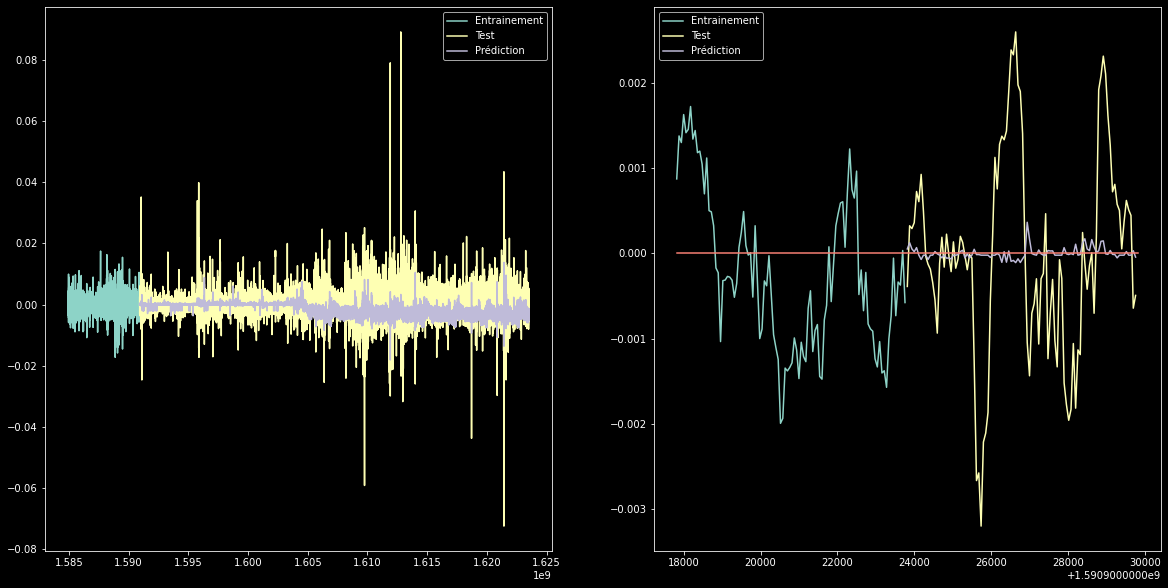

In [16]:
plot_them(y_train, y_test, y_test_pred, first=30)

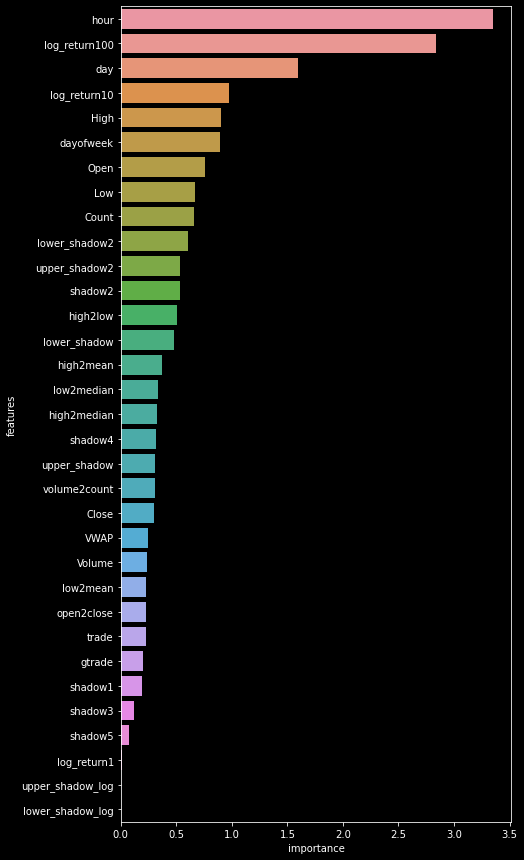

In [59]:
# feature importance
fi_df = pd.DataFrame()
fi_df['features'] = X.columns
fi_df['importance'] = model.booster_.feature_importance(importance_type="gain")

fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(x='importance', y='features', data=fi_df.sort_values(by=['importance'], ascending=False), ax=ax)
plt.show()

## XGBoost

In [17]:
params = {
    'n_estimators': 500,
    # 'max_depth': 13,
    # 'learning_rate': 0.04,
    # 'subsample': 0.9,
    # 'colsample_bytree': 0.7,
    'missing': -999,
    'random_state': 42,
    'tree_method': 'gpu_hist'}
model = xgb.XGBRegressor(**params)
pipe3 = pipeline.Pipeline(steps=[
    ('scaler', scaler),
    ('model', model)])
pipe3.fit(X_train, y_train)

y_train_pred = pipe3.predict(X_train)
y_test_pred = pipe3.predict(X_test)

In [18]:
print('     Training | Test')
print(f'MSE  {np.mean((y_train - y_train_pred)**2):8.2e} | {np.mean((y_test - y_test_pred)**2):8.2e}')
print(f'CV   {stats.pearsonr(y_train, y_train_pred)[0]:8.6f} | {stats.pearsonr(y_test, y_test_pred)[0]:8.6f}')

     Training | Test
MSE  2.68e-06 | 2.55e-05
CV   0.547071 | -0.002469


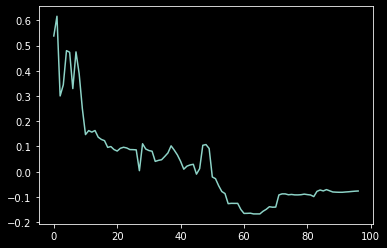

In [19]:
corrs = []
for i in range(3, 100):
    corrs.append( stats.pearsonr(y_test[:i], y_test_pred[:i])[0] )
plt.plot(corrs)
plt.show()

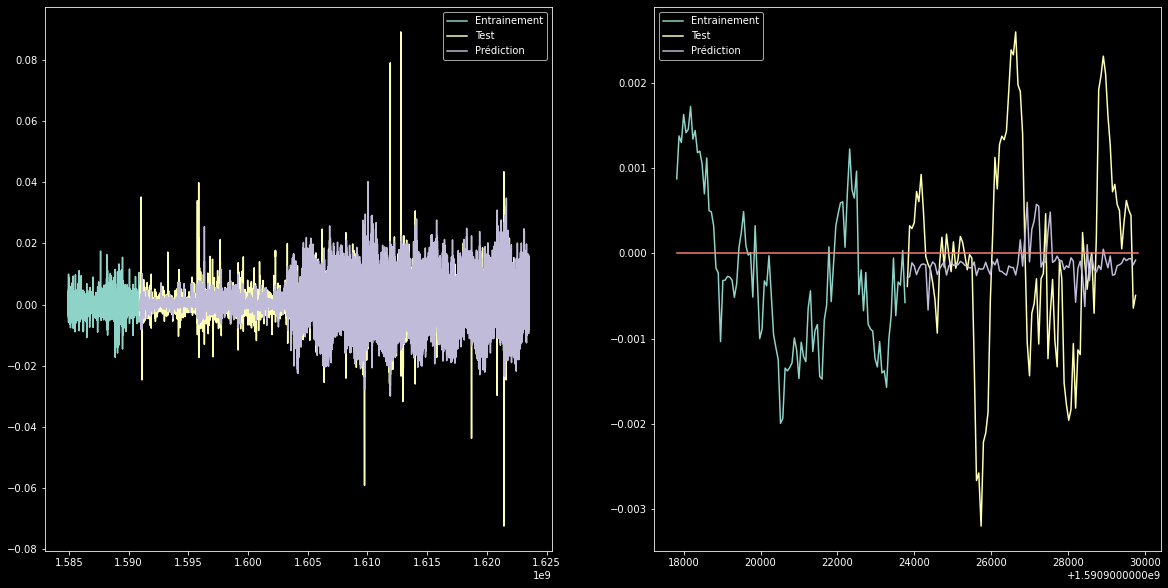

In [20]:
plot_them(y_train, y_test, y_test_pred, first=30)

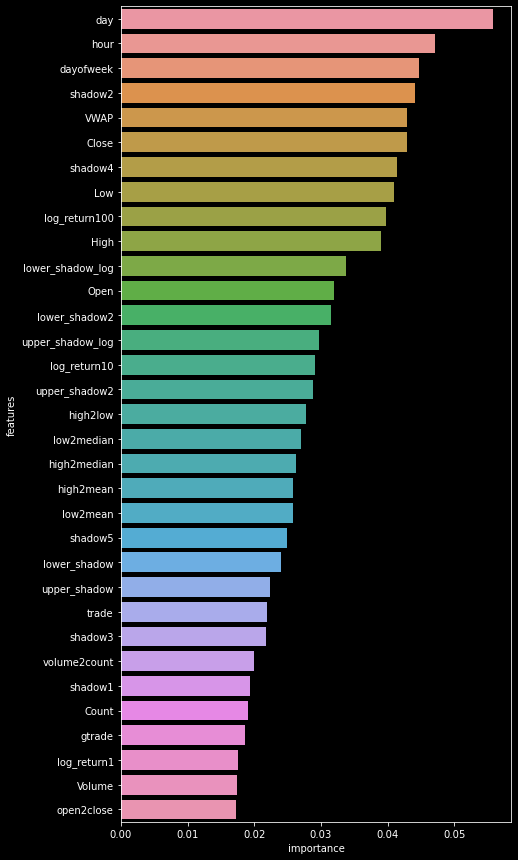

In [75]:
# feature importance
fi_df = pd.DataFrame()
fi_df['features'] = X.columns
fi_df['importance'] = model.feature_importances_

fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(x='importance', y='features', data=fi_df.sort_values(by=['importance'], ascending=False), ax=ax)
plt.show()

# Preparation 2

In [6]:
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features2(df, lag=1):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    
    df_feat.fillna(-999,inplace=True)
    df_feat = df_feat.diff()
    # add lagged observations
    df_feat = series_to_supervised(df_feat, n_in=lag)
    df_feat['Upper_Shadow'] = upper_shadow(df)
    df_feat['Lower_Shadow'] = lower_shadow(df)
    return df_feat

def series_to_supervised(data, n_in=1, dropnan=True, interpolate=False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a DataFrame.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    vars = data.columns
    df = data.copy()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var}(t-{i})' for var in vars]
    # forecast sequence (t)
    cols.append(df.shift(0))
    names += vars.tolist()
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    if interpolate:
        agg.interpolate(method='linear', inplace=True)
    return agg

In [17]:
df = pd.read_csv(data_folder + 'train.csv', index_col=0).pipe(reduce_mem_usage)
df.replace([np.inf, -np.inf], np.nan)
df_btc = df[df["Asset_ID"] == 1][:-16]
df_proc2 = get_features2(df_btc, lag=1)
df_proc2['y'] = df_btc['Target']
df_proc2 = df_proc2.dropna(how="any")

Memory usage of dataframe is 1849.12 MB
Memory usage after optimization is: 808.99 MB
Decreased by 56.2%


In [18]:
X = df_proc2.drop("y", axis=1)
y = df_proc2["y"]
N = len(X)
test_size = 0.3
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
X_train2, X_test2 = X[:-int(N*test_size)], X[-int(N*test_size):]
y_train2, y_test2 = y[:-int(N*test_size)], y[-int(N*test_size):]
scaler = preprocessing.StandardScaler()

## XGB Lag

In [19]:
model = xgb.XGBRegressor(
    n_estimators=500,
    # learning_rate=0.05,
    # max_depth=12,
    # subsample=0.9,
    # colsample_bytree=0.7,
    # colsample_bylevel=0.75,
    missing=-999,
    random_state=1111,
    tree_method='gpu_hist')

pipe4 = pipeline.Pipeline(steps=[
    ('scaler', scaler),
    ('model', model)])
pipe4.fit(X_train2, y_train2)

y_train_pred = pipe4.predict(X_train2)
y_test_pred = pipe4.predict(X_test2)

In [20]:
print('     Training | Test')
print(f'MSE  {np.mean((y_train2 - y_train_pred)**2):8.2e} | {np.mean((y_test2 - y_test_pred)**2):8.2e}')
print(f'CV   {stats.pearsonr(y_train2, y_train_pred)[0]:8.6f} | {stats.pearsonr(y_test2, y_test_pred)[0]:8.6f}')

     Training | Test
MSE  2.99e-06 | 1.06e-05
CV   0.426236 | -0.002090


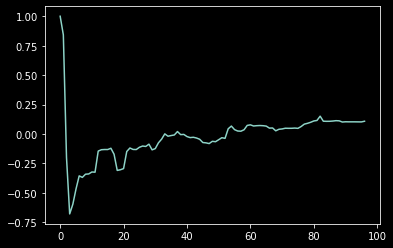

In [21]:
corrs = []
for i in range(3, 100):
    corrs.append( stats.pearsonr(y_test2[:i], y_test_pred[:i])[0] )
plt.plot(corrs)
plt.show()

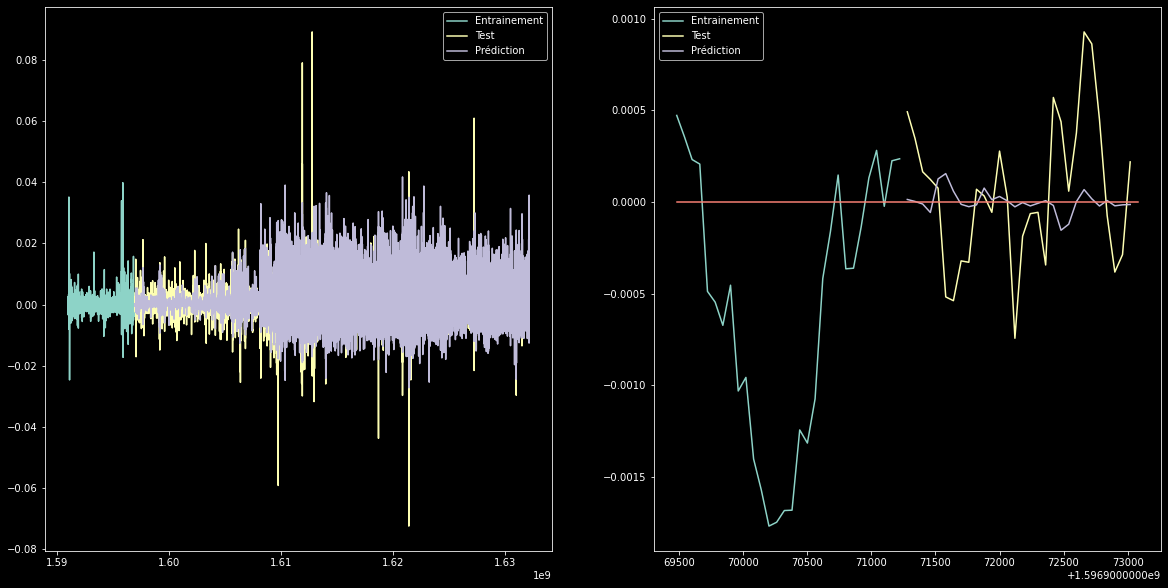

In [22]:
plot_them(y_train2, y_test2, y_test_pred, first=30)

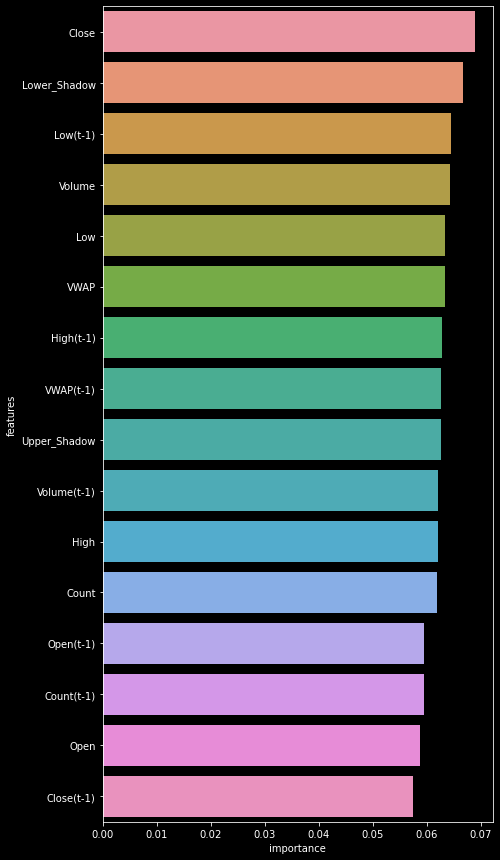

In [15]:
# feature importance
fi_df = pd.DataFrame()
fi_df['features'] = X.columns
fi_df['importance'] = pipe4.steps[1][1].feature_importances_

fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(x='importance', y='features', data=fi_df.sort_values(by=['importance'], ascending=False), ax=ax)
plt.show()

## All together

In [ ]:
df_small = df[df.index > 1555564860]

In [151]:
df_small

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
timestamp,,,,,,,,,,
1555564920,2,22.0,310.500000,311.000000,309.500000,310.500000,1.371303e+01,310.527173,0.001473,2019-04-18 05:22:00
1555564980,2,48.0,310.250000,310.750000,309.250000,310.000000,9.089226e+01,310.084597,0.002119,2019-04-18 05:23:00
1555565040,2,48.0,310.250000,310.750000,309.000000,310.000000,2.060278e+01,310.111366,0.000830,2019-04-18 05:24:00
1555565100,2,70.0,310.250000,310.750000,309.000000,310.250000,9.427962e+01,310.206743,0.003487,2019-04-18 05:25:00
1555565160,2,34.0,310.000000,310.750000,309.250000,310.250000,3.483339e+01,310.042181,0.002531,2019-04-18 05:26:00
...,...,...,...,...,...,...,...,...,...,...
1623542100,4,410.0,0.312012,0.312256,0.311768,0.312012,7.627430e+05,0.312071,-0.000763,2021-06-12 23:55:00
1623542160,4,356.0,0.312012,0.312500,0.311768,0.312012,4.796375e+05,0.312121,-0.000619,2021-06-12 23:56:00
1623542220,4,518.0,0.311768,0.312012,0.311279,0.311523,8.835752e+05,0.311586,-0.000163,2021-06-12 23:57:00


In [ ]:
def get_features(df_asset):
    for ID in df_asset.Asset_ID.unique():
        
    df = df_asset[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df['upper_shadow'] = df['High'] / df[['Close', 'Open']].max(axis=1)
    df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) / df['Low']
    df['open2close'] = df['Close'] / df['Open']
    df['high2low'] = df['High'] / df['Low']
    mean_price = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    df['high2mean'] = df['High'] / mean_price
    df['low2mean'] = df['Low'] / mean_price
    median_price = df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df['high2median'] = df['High'] / median_price
    df['low2median'] = df['Low'] / median_price
    df['volume2count'] = df['Volume'] / (df['Count'] + 1)
    df['upper_shadow2'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shadow2'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df['trade'] = df['Close'] - df['Open']
    df['gtrade'] = df['trade'] / df['Count']
    df['shadow1'] = df['trade'] / df['Volume']
    df['shadow2'] = df['upper_shadow'] / df['Low']
    df['shadow3'] = df['upper_shadow'] / df['Volume']
    df['shadow4'] = df['lower_shadow'] / df['High']
    df['shadow5'] = df['lower_shadow'] / df['Volume']
    df['upper_shadow_log'] = np.log(df['upper_shadow'])
    df['lower_shadow_log'] = np.log(df['lower_shadow'])
    df['log_return1'] = log_return(df['Close'], periods=1)
    df['log_return1'] = log_return(df['Close'], periods=1)
    df['log_return10'] = log_return(df['Close'], periods=10)
    df['log_return10'] = log_return(df['Close'], periods=10)
    df['log_return100'] = log_return(df['Close'], periods=100)
    df['log_return100'] = log_return(df['Close'], periods=100)
    times = pd.to_datetime(df.index, unit="s", infer_datetime_format=True)
    df["hour"] = times.hour
    df["dayofweek"] = times.dayofweek 
    df["day"] = times.day 
    # drops = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
    # df.drop(drops, axis=1, inplace=True)
    return df

In [ ]:
model = lgb.LGBMRegressor(**params)
model.fit(
    feature_df.query('train_flg == 1')[features],
    feature_df.query('train_flg == 1')[target].values, 
    eval_set=[(feature_df.query('train_flg == 0')[features]
               , feature_df.query('train_flg == 0')[target].values)],
    verbose=-1, 
    early_stopping_rounds=100,
    categorical_feature=categoricals,
)


---
# Autres

## Progressif

In [ ]:
model = linear_model.LinearRegression()
pipe1 = pipeline.Pipeline(steps=[
    ('scaler', scaler),
    ('linear', model)])
pipe1.fit(X_train, y_train)
y_train_pred = pipe1.predict(X_train)
y2 = y.copy()
y_test_pred = []
for i in range(30):
    y_pred = pipe1.predict(X_test[i:i+1])
    y2[-int(N*test_size)+i:-int(N*test_size)+i+1] = y_pred
    y_test_pred.append( y_pred )
    pipe1.fit(X[:-int(N*test_size)+i+1], y2[:-int(N*test_size)+i+1])

In [ ]:
stats.pearsonr(y_test[:635], y_test_pred[:635])[0]

array([-0.04453493468118207], dtype=object)

In [ ]:
print('     Training | Test')
print(f'MSE  {np.mean((y_train - y_train_pred)**2):8.2e} | {np.mean((y_test - y_test_pred)**2):8.2e}')
print(f'CV   {stats.pearsonr(y_train, y_train_pred)[0]:8.6f} | {stats.pearsonr(y_test, y_test_pred)[0]:8.6f}')

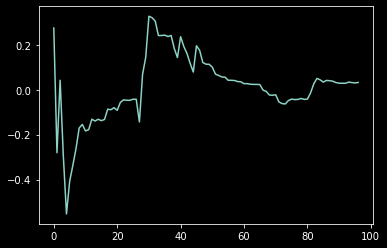

In [ ]:
corrs = []
for i in range(3, 100):
    corrs.append( stats.pearsonr(y_test[:i], y_test_pred[:i])[0] )
plt.plot(corrs)
plt.show()

---
# Soumission

Il s'agit d'un concours de code, dans lequel nous devons soumettre une Notebook pour qu'elle soit exécuté avec les données privées cachées. 
La Notebook doit utiliser l'API de série temporelle python fournie, qui garantit que les modèles n'apparaissent pas dans le temps. 
Pour utiliser l'API, les instructions et l'exemple sont détaillées ici : [Detailed API Introduction](https://www.kaggle.com/sohier/detailed-api-introduction) et [Basic Submission Template](https://www.kaggle.com/sohier/basic-submission-template).